Working at an insurance company has opened my eyes to the balance needed to offer affordable services yet still stay afloat as a company. Competition drives us to tailor health insurance to each population so that healthy populations are not mostly paying to subsidize less healthy populations, though this often does occur. So how can we prevent unfair premiums? By understanding our population better.

State Farm has different concerns, but the objective remains the same. They want to know how to detect differences between high risk populations and low risk ones. This allows them to cater their products so that both the company and the customer sees value in their relationship. What better way to know how risky a driver is than to see exactly how they drive?

This project attempts to see if using Convolutional Neural Networks can allow us to detect if drivers are distracted while at the wheel or driving as they should. A camera was installed in multiple cars with multiple actors, all simulating normal activities while driving. Unfortunately normal activities usually include texting, operating the radio, eating/drinking, reaching behind to the back seat, doing hair and makeup, or talking to the passenger. My model below detects the probability of each of these states given the image.

First let's clean and prepare our data to be ingested into the CNN.

In [1]:
import time
import os
import glob
import numpy as np
from PIL import Image
import h5py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Get each image filepath into a list
img_list = glob.glob("C:/Users/mitar/ia/Distracted-Drivers-Detection-master/train/**/*.jpg")
img_list[:5]

['C:/Users/mitar/ia/Distracted-Drivers-Detection-master/train\\c0\\img_104.jpg',
 'C:/Users/mitar/ia/Distracted-Drivers-Detection-master/train\\c0\\img_139.jpg',
 'C:/Users/mitar/ia/Distracted-Drivers-Detection-master/train\\c0\\img_208.jpg',
 'C:/Users/mitar/ia/Distracted-Drivers-Detection-master/train\\c0\\img_231.jpg',
 'C:/Users/mitar/ia/Distracted-Drivers-Detection-master/train\\c0\\img_262.jpg']

Since my computer has 16GB of RAM and 4GB of GPU RAM I will resize the image to 1/16th the size by dividing the pixel height and width by 4. Also, these images have 3 channels of color (RGB) which do not inform the outcome variable. I also do not want the model to incorrectly learn from the colors since body position and focus is what the model should really be picking up. For this reason I convert each image to gray scale.

In [2]:
# Load in ALL train images and label them
actual_images = []
X = []
y = []

start = time.time()

for j in range(10):
    print('Load folder c{}'.format(j))
    path = os.path.join('.', 'train', 'c' + str(j), '*.jpg')
    img_list = glob.glob(path)
    for file in img_list:
        # Open each image and convert to black and white
        img = Image.open(file).convert('L')
        # Get image height and width to divide each by 2 (save memory)
        height, width = img.size
        # thumbnail is an in-place operation
        img.thumbnail((height/4, width/4), Image.ANTIALIAS)
        # Make each image into a numpy array divided by the max to get 0 to 1 normalization
        img_data = np.array(img.getdata()) / 255
        # Grow lists of actual images, image data, and labels
        actual_images.append(img)
        X.append(img_data)
        y.append(j)
# Combine list of images into numpy array
X = np.array(X, dtype = 'float32')    

end = time.time()

print()
print("Loading and cleaning images took %s" % str(end - start), "seconds", '\n')
print("Number of train images: %s" % len(X))

Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9

Loading and cleaning images took 1.2462098598480225 seconds 

Number of train images: 120


[0]


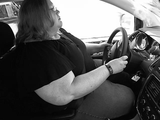

In [3]:
# Show an example of an image and some labels
print(y[0:20000:5000])
actual_images[0]

In [4]:
# Make sure to save both the cleaned inputs and the cleaned target
X_h5 = h5py.File('X.h5', 'w')
X_h5.create_dataset('X_h5', data=X)
X_h5.close()

y_h5 = h5py.File('y.h5', 'w')
y_h5.create_dataset('y_h5', data=y)
y_h5.close()

Now with our images preprocessed and put into numeric format, we can move forward with dividing up the samples into test and train data We then also need to make sure the data shape is prepared in Tensorflow format and that the labels are dummy coded so that Keras can interpret the labels correctly.

In [5]:
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, Callback
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Flatten
from keras.utils import to_categorical
from keras import backend as K
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

# This make sure the input shape is: (number of samples, width, height, channels)
K.set_image_dim_ordering('tf')

# Load in preprocessed data
with h5py.File('X.h5', 'r') as hf:
    X = hf['X_h5'][:]
with h5py.File('y.h5', 'r') as hf:
    y = hf['y_h5'][:]

# Get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle = True)

# Prepare images to correct shape for Keras model
X_train = X_train.reshape(X_train.shape[0], 160, 120, 1)
X_test= X_test.reshape(X_test.shape[0], 160, 120, 1)
y_train = to_categorical(y_train).astype('int32')
y_test = to_categorical(y_test).astype('int32')

# Check data to see if everything is ok
print(" 'X' matrix/input ")
print("Shape: ", str(X_train.shape))
print(X_train[0][0][:5], '\n')
print(" 'y' label/output ")
print("Shape: ", str(y_train.shape))
print(y_train)

Using TensorFlow backend.


 'X' matrix/input 
Shape:  (96, 160, 120, 1)
[[0.16470589]
 [0.16470589]
 [0.16470589]
 [0.16470589]
 [0.16862746]] 

 'y' label/output 
Shape:  (96, 10)
[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 

c:\users\mitar\ia\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Alright, everything looks ready for modeling. Before doing so I want to cover a new learning rate scheduling technique. Below is a cosine annealing learning rate scheduler with restarts coded by from Jeremy Jordan, a fellow deep learning practitioner on GitHub. It lets you choose a learning rate range to work between and decreases over a set number of epochs. Once it reaches the minimum learning rate it does one last epoch, followed directly by the max learning rate. This decrease in learning rate over epochs starts slowly and then increases at the rate of the cosine function. This process repeats as many times as one likes, potentially over different numbers of epochs.  Here is an example image of the idea:

![SGDR Scheduler](https://cdn-images-1.medium.com/max/1200/1*nBTMGa3WqhS2Iq4gCeCZww.png)

This technique allows one to carefully find their way into a local minima and then jump out with the jump in learning rate if the local minima is not generalizable. More explanation of this technique can be found here: https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b

In [6]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

Train on 76 samples, validate on 20 samples
Epoch 1/15
76/76 [==============================] - 56s 743ms/step - loss: 2.9707 - acc: 0.1316 - val_loss: 15.3122 - val_acc: 0.0500
Epoch 2/15
76/76 [==============================] - 54s 709ms/step - loss: 2.3318 - acc: 0.1974 - val_loss: 9.6600 - val_acc: 0.1500
Epoch 3/15
76/76 [==============================] - 54s 707ms/step - loss: 1.9963 - acc: 0.2237 - val_loss: 7.9327 - val_acc: 0.2500
Epoch 4/15
76/76 [==============================] - 54s 705ms/step - loss: 1.8903 - acc: 0.3289 - val_loss: 7.1174 - val_acc: 0.2000
Epoch 5/15
76/76 [==============================] - 55s 726ms/step - loss: 1.8787 - acc: 0.3289 - val_loss: 5.2724 - val_acc: 0.3000
Epoch 6/15
76/76 [==============================] - 57s 749ms/step - loss: 1.9652 - acc: 0.3026 - val_loss: 9.6266 - val_acc: 0.1500
Epoch 7/15
76/76 [==============================] - 56s 737ms/step - loss: 1.8366 - acc: 0.3026 - val_loss: 11.5867 - val_acc: 0.1500
Epoch 8/15
76/76 [=====

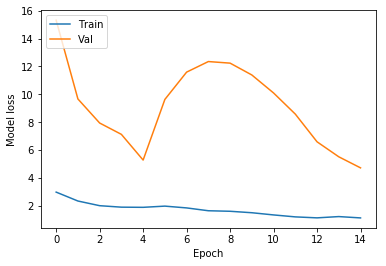

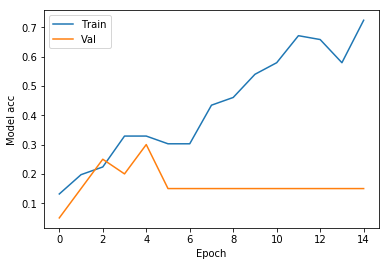

In [7]:
batch_size = 32

# Use next line if not doing cosine annealing
# early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

schedule = SGDRScheduler(min_lr=1e-4,
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(X_train.shape[0]/batch_size),
                         lr_decay=0.8,
                         cycle_length=5,
                         mult_factor=2)

def DD_VGG():
    model = Sequential()
    # Use Batch Normalization for every conv and dense layers
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (160, 120, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.33))
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation = 'softmax')) # Sigmoid for log loss?
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model

driver_model = DD_VGG()
driver_hist = driver_model.fit(X_train, y_train, epochs=15, batch_size=batch_size, verbose=1,
                               validation_split=0.2, callbacks=[schedule])

def plot_model(model_hist, train_metric, val_metric):
    plt.plot(model_hist[train_metric])
    plt.plot(model_hist[val_metric])
    plt.ylabel('Model ' + str(train_metric))
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_model(driver_hist.history, 'loss', 'val_loss')
plot_model(driver_hist.history, 'acc', 'val_acc')

In [8]:
# Save model when retraining
driver_model.save('./driver_model.h5')
#driver_model = load_model('./driver_model.h5')

# Save model history
with open('./trainHistoryDict', 'wb') as history:
        pickle.dump(driver_hist.history, history)

In [9]:
# Get predictions and make them into vector of 0 to 9
test_pred = driver_model.predict(X_test)
test_pred2 = np.argmax(test_pred, axis = 1)

# Change dummy code matrix back to vector of 0 to 9
y_test2 = np.argmax(y_test, axis = 1)

# Get performance
print(confusion_matrix(y_test2, test_pred2))
print("Test set accuracy is: %s" % accuracy_score(y_test2, test_pred2))

[[2 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [4 0 1 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]]
Test set accuracy is: 0.08333333333333333


In [10]:
# Free up memory for submission data
%reset

# Re-import needed modules
import glob
import os
import numpy as np
from PIL import Image
from keras.models import load_model
import pandas as pd

submission_data = []
filenames = []

img_list = sorted(glob.glob("C:/Users/mitar/ia/Distracted-Drivers-Detection-master/test/*.jpg"))
for file in img_list:
     # Open each image and convert to black and white
    img = Image.open(file)
    filenames.append(os.path.basename(img.filename))
    img = img.convert('L')
    # Get image height and width to divide each by 4 (save memory)
    # thumbnail is an in-place operation
    img.thumbnail((img.size[0]/4, img.size[1]/4), Image.ANTIALIAS)
    # Make into numpy array divided by the max to get 0 to 1 normalization
    img_data = np.array(img.getdata()) / 255
    submission_data.append(img_data)

print()
print("Number of test images: %s" % len(submission_data))

# Make list into numpy array and reshape to feed into model
submission_data = np.array(submission_data, dtype = 'float32')
submission_data = submission_data.reshape(submission_data.shape[0], 160, 120, 1)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y

Number of test images: 24


In [11]:
# Load in model and use it to predict
driver_model = load_model('./driver_model.h5')
 
# Get log probabilities
kaggle_log_probs = driver_model.predict(submission_data)
kaggle_log_probs = pd.DataFrame(kaggle_log_probs, index = filenames, columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])

kaggle_log_probs.to_csv('./DD_kaggle_submission.csv', sep=',', encoding='utf-8')

In [12]:
import pandas as pd
kaggle_submission = pd.read_csv('./DD_kaggle_submission.csv')

print(kaggle_submission.head(10))
print(kaggle_submission.info())

       Unnamed: 0        c0            c1        c2        c3        c4  \
0       img_1.jpg  0.910335  7.142236e-05  0.015315  0.012548  0.007306   
1      img_10.jpg  0.158129  4.534117e-04  0.659940  0.057459  0.008073   
2     img_100.jpg  0.936724  4.319017e-05  0.006643  0.008382  0.004995   
3    img_1000.jpg  0.992770  3.730581e-07  0.000975  0.001028  0.001432   
4  img_100000.jpg  0.886591  5.902228e-05  0.017415  0.008627  0.003761   
5  img_100001.jpg  0.840707  3.476412e-05  0.008358  0.010146  0.012483   
6  img_100002.jpg  0.924595  8.867945e-06  0.004789  0.006894  0.003097   
7  img_100003.jpg  0.957919  1.548045e-06  0.002940  0.002297  0.001858   
8  img_100004.jpg  0.339485  4.623199e-04  0.403307  0.068838  0.010319   
9  img_100005.jpg  0.815235  3.467678e-05  0.049398  0.023075  0.004433   

         c5        c6        c7        c8        c9  
0  0.037691  0.002694  0.005131  0.000377  0.008532  
1  0.042040  0.002334  0.014210  0.005791  0.051570  
2  0.006007 